In [34]:
import numpy as np
import seaborn
import networkx as nx
from networkx import from_numpy_array, draw_networkx,eigenvector_centrality, average_shortest_path_length, harmonic_centrality, global_efficiency

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt
import torch.nn.functional as F
from sklearn.model_selection import train_test_split


In [35]:
matrix = np.load('GC_matrix.npy')

In [36]:
fname =['steinmetz_part0.npz', 'steinmetz_part1.npz', 'steinmetz_part2.npz']
alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

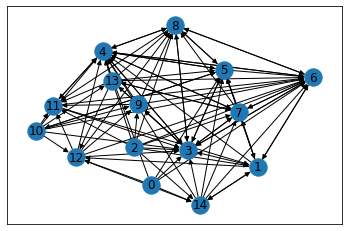

In [201]:
matrix_0 = matrix[0]
matrix_0[matrix_0 < np.mean(matrix[0])] = 0
matrix_0[matrix_0 > 0] = 1
draw_networkx(from_numpy_array(matrix_0, parallel_edges=False, create_using = nx.DiGraph))

In [152]:
mod_l = []
for i in range(250):
    each_m = matrix[i]
    each_m[each_m < np.mean(matrix[i])] = 0
    each_m[each_m > 0] = 1
    mod_l.append(each_m)
mod_l[1]

array([[0., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1.],
       [1., 0., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1.],
       [1., 1., 0., 1., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1.],
       [1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0.],
       [1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.],
       [1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0.],
       [0., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 0.],
       [1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1.],
       [1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0.],
       [1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1.],
       [1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1.],
       [1., 1., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0.],
       [1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1.],
       [1., 1., 0., 1., 1., 1., 1.

In [153]:
list_ei = []
# iterate graph analysis through each connectivity matrix and stores the result in a list

r = 250
for idx in range(r): 
    list_ei.append(list(harmonic_centrality(from_numpy_array(mod_l[idx], parallel_edges=False, create_using=nx.DiGraph)).values()))

In [174]:
X_cen = np.array(list_ei)
stack = np.hstack((X_cen, alldat[7]['response_time']))

In [183]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
#X = torch.tensor(list_ei)
X=torch.tensor(stack, dtype=torch.float)
Y = alldat[7]['feedback_type']
#Y = torch.tensor(alldat[7]['feedback_type'], dtype = torch.long)
#Y = Y.flatten()
#np.put(Y, hard_correct_choice, [2])
#Y = torch.tensor(Y, dtype = torch.long)
Y = torch.tensor(Y, dtype=torch.long)
Y[Y== -1] = 0
#Y = torch.tensor(alldat[7]['feedback_type'], dtype = torch.long)
#correct = np.where(Y==1)
#Y = torch.tensor(alldat[7]['feedback_type'], dtype = torch.long)

In [184]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=6)

In [185]:
# Create the data class

class Data(Dataset):
    
    # Constructor
    def __init__(self, train = True):
        if (train):
            self.x = x_train
            self.y = y_train
            self.len = self.x.shape[0]
            
        else: 
            self.x = x_test
            selfy = y_test
        
    
    # Getter
    def __getitem__(self, index):      
        return self.x[index], self.y[index]
    
    # Get length
    def __len__(self):
        return self.len

In [186]:
train_set=Data()
test_set = Data(train = False)
train_loader = DataLoader(dataset=train_set, batch_size = 128)
test_loader = DataLoader(dataset=test_set, batch_size = 2)

In [187]:
# Create the neural network

class Net(nn.Module):
    
    def weights_init(m):
        if isinstance(m, torch.relu):
            torch.nn.init.kaiming_uniform_(m.weight.data)
            torch.nn.init.kaiming_uniform_(m.bias.data)
        elif isinstance(m, F.softmax):
            torch.nn.init.xavier_normal_(m.weight.data)
            torch.nn.init.xavier_normal_(m.bias.data)
        
        
    # Constructor
    def __init__(self, D_in, H1, H2, H3, D_out):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, H3)
        self.linear4 = nn.Linear(H3, D_out)
    
    # Prediction
    def forward(self, x):
        x = torch.relu(self.linear1(x))
        x = torch.relu(self.linear2(x))
        x = torch.relu(self.linear3(x))
        x = F.softmax(self.linear4(x))
        return x

In [188]:
# Define the function for training the model

LOSS = []  
#min_loss = 0.3

def train(data_set, model, criterion, train_loader, optimizer, epochs):
    for epoch in range(epochs):
        for x, y in train_loader:
            yhat = model(x.float())
            loss = criterion(yhat, y)
            #loss_val = criterion(model(val_dataset.x), val_dataset.y).item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            LOSS.append(loss.item())
            #if loss < min_loss:
             #   break
            #VAL.append(val.item)

In [189]:
D_in = 16
H1 = 120
H2 = 140
H3 = 120
D_out = 3

# Batch size = 164
model = Net(D_in, H1, H2, H3, D_out)
#model.apply(initialize_weights)
learning_rate = 0.00004
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

<ipython-input-187-1f0a6e7f01a0>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.linear4(x))


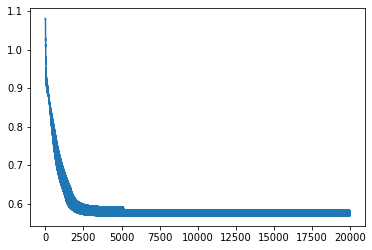

In [190]:
train(train_set, model, criterion, train_loader, optimizer, epochs= 10000)
plt.plot(LOSS)

In [198]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(X, Y, test_size=0.25, random_state=11)
x_train2, x_test2, y_train2, y_test2 = train_test_split(X, Y, test_size=0.25, random_state=23)
x_train3, x_test3, y_train3, y_test3 = train_test_split(X, Y, test_size=0.25, random_state=33)
x_train4, x_test4, y_train4, y_test4 = train_test_split(X, Y, test_size=0.25, random_state=44)
x_train5, x_test5, y_train5, y_test5 = train_test_split(X, Y, test_size=0.25, random_state=55)

In [199]:
from sklearn.metrics import accuracy_score


pred1 = model(x_test1)
_, predict_classes1 = torch.max(pred1,1)

correct1 = accuracy_score(y_test1, predict_classes1)
print('Test Accuracy1:', correct1)
############
pred2 = model(x_test2)
_, predict_classes2 = torch.max(pred2,1)

correct2 = accuracy_score(y_test2, predict_classes2)
print('Test Accuracy2:', correct2)
###########
pred3 = model(x_test3)
_, predict_classes3 = torch.max(pred3,1)

correct3 = accuracy_score(y_test3, predict_classes3)
print('Test Accuracy3:', correct3)
############
pred4 = model(x_test4)
_, predict_classes4 = torch.max(pred4,1)

correct4 = accuracy_score(y_test4, predict_classes4)
print('Test Accuracy4:', correct4)

############
pred5 = model(x_test5)
_, predict_classes5 = torch.max(pred5,1)

correct5 = accuracy_score(y_test5, predict_classes5)
print('Test Accuracy5:', correct5)

Test Accuracy1: 0.9365079365079365
Test Accuracy2: 0.9206349206349206
Test Accuracy3: 0.8888888888888888
Test Accuracy4: 0.9523809523809523
Test Accuracy5: 0.8571428571428571


<ipython-input-187-1f0a6e7f01a0>:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.softmax(self.linear4(x))


In [193]:
torch.save(model.state_dict(), 'GC best M')

In [ ]:
#########